# Matthew Verish
# HW3 
# Kaggle name: one is Matt V, the other is MATTHEWJAMESVERISH

I changed my kaggle name and it showed up as the new one in one competition but not the other.

Some of the code didn't show up well in the jupyter pdf, so look in the code I upload to gradescope if you need to see.

# Problem 2

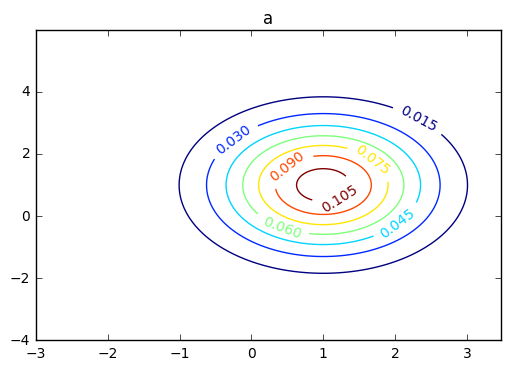

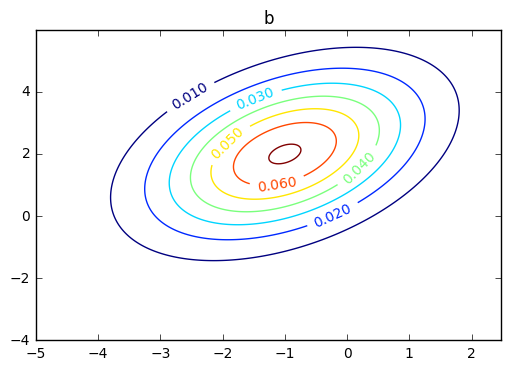

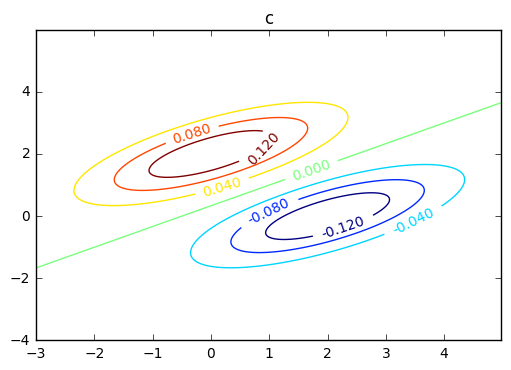

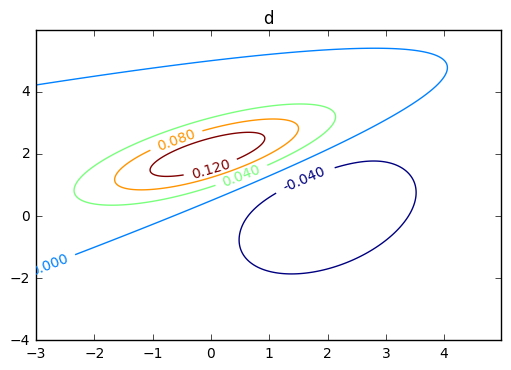

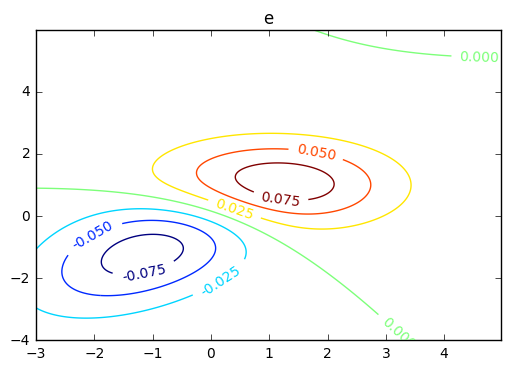

In [2]:
from __future__ import division
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.io
import collections
import cv2
import skimage.measure
import skimage.transform
import skimage.filters
import skimage.morphology
import math
from PIL import Image
import sklearn.preprocessing


delta = 0.025
x = np.arange(-3.0, 3.5, delta)
y = np.arange(-4.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, 1, np.sqrt(2), 1, 1, 0)



# Create a simple contour plot with labels using default colors.  The
# inline argument to clabel will control whether the labels are draw
# over the line segments of the contour, removing the lines beneath
# the label
plt.figure()
CS = plt.contour(X, Y, Z1)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('a')

plt.show()


x = np.arange(-5.0, 2.5, delta)
y = np.arange(-4.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
Z2 = mlab.bivariate_normal(X, Y, np.sqrt(2), np.sqrt(3), -1, 2, 1)

plt.figure()
CS = plt.contour(X, Y, Z2)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('b')

plt.show()


x = np.arange(-3.0, 5.0, delta)
y = np.arange(-4.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
temp1 = mlab.bivariate_normal(X, Y, np.sqrt(2), 1, 0, 2, 1)
temp2 = mlab.bivariate_normal(X, Y, np.sqrt(2), 1, 2, 0, 1)
Z3 = temp1 - temp2

plt.figure()
CS = plt.contour(X, Y, Z3)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('c')

plt.show()

x = np.arange(-3.0, 5.0, delta)
y = np.arange(-4.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
temp1 = mlab.bivariate_normal(X, Y, np.sqrt(2), 1, 0, 2, 1)
temp2 = mlab.bivariate_normal(X, Y, np.sqrt(2), np.sqrt(3), 2, 0, 1)
Z4 = temp1 - temp2

plt.figure()
CS = plt.contour(X, Y, Z4)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('d')

plt.show()

x = np.arange(-3.0, 5.0, delta)
y = np.arange(-4.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
temp1 = mlab.bivariate_normal(X, Y, np.sqrt(2), 1, 1, 1, 0)
temp2 = mlab.bivariate_normal(X, Y, np.sqrt(2), np.sqrt(2), -1, -1, 1)
Z5 = temp1 - temp2

plt.figure()
CS = plt.contour(X, Y, Z5)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('e')

plt.show()
    

# Problem 6 

Here I am fitting a gaussian distribution by calculating the covariance and mean matrices. Below is a visualization og the covariance matrix, which from the picture has higher values on the diagonal than on the off diagonals. This suggests that pixels that are closer together have higher covariances than those far apart, which makes intuitive sense.

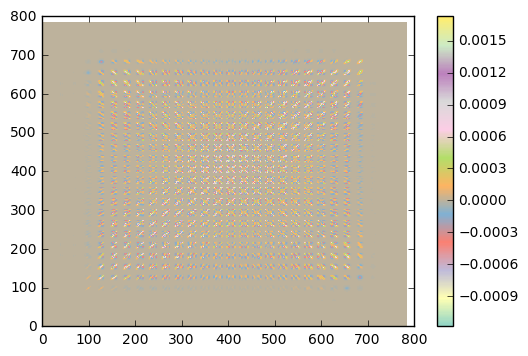

In [7]:
mnist_raw_data = scipy.io.loadmat('hw3_mnist_dist\\hw3_mnist_dist\\train.mat')['trainX']
sorted_data = {0: [], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
for elem in mnist_raw_data:
    index = elem[-1]
    elem = elem/np.linalg.norm(elem)
    sorted_data[index].append(elem[:-1])

mean_arrays = {}
cov_arrays = {}
for i in range(10):
    sorted_data[i] = np.asarray(sorted_data[i])
    mean_arrays[i] = np.empty(784)
    cov_arrays[i] = np.cov(sorted_data[i].T)
    for j in range(784):
        mean_arrays[i][j] = np.mean(sorted_data[i][:,j])

plt.pcolor(cov_arrays[0], cmap = 'Set3')
plt.colorbar()
plt.show()



I made a Gaussian Classifier object to make it easier to implement QDA and LDA. In the full code below i include my code for deskewing objects as well as training on the HOG of the images instead of the raw pixels. I disabled these features and simply trained on normalized pixels for everything but Kaggle.

In [6]:
#A Gaussian classifier object, takes in an array of labels, and a value C, 
#a scalar hyper-parameter used for estimating
#inverses when the covariance matrix is singular.

class Gaussian_classifier():
    cov_matrices = {}
    inv_matrices = {}
    det = {}
    avg_cov_matrix = None
    cov_inverse = None
    labels = None
    mean_matrices = {}
    C = 1.0

    def __init__(self, labels, C=1.0):
        self.C = C
        self.labels = labels

    #Fit the classifier to the given data, this involves 
    #calculating the covariance matrices, average covariance matrices, 
    #determinants, and mean matrices to be used when classifying.
    def fit(self, data):
        sorted_data = collections.defaultdict(list)
        for elem in data:
            index = elem[-1]
            elem = self.preProcess(elem[:-1])
            sorted_data[index].append(elem)
        for index in self.labels:
            sorted_data[index] = np.asarray(sorted_data[index])
            self.mean_matrices[index] = np.empty(len(sorted_data[index][0]))
            self.cov_matrices[index] = np.cov(sorted_data[index].T)
            for k in range(len(sorted_data[index][0])):
                self.mean_matrices[index][k] = np.mean(sorted_data[index][:, k])
        self.avg_cov_matrix = sum(list(self.cov_matrices.values())) 
                                    / len(self.labels)
        if np.linalg.det(self.avg_cov_matrix) == 0:
            self.avg_cov_matrix = self.avg_cov_matrix + + self.C * 
                                    np.identity(self.avg_cov_matrix.shape[0])
            self.cov_inverse = np.linalg.inv(self.avg_cov_matrix)
        for index in self.labels:
            #if np.linalg.det(self.cov_matrices[index]) == 0:
            self.cov_matrices[index] = self.cov_matrices[index] + self.C 
                                * np.identity(self.cov_matrices[index].shape[0])
            self.inv_matrices[index] = np.linalg.inv(self.cov_matrices[index])
            self.det[index] = np.linalg.slogdet(self.cov_matrices[index])

            
    #classify a given point using LDA
    def LDA_classify(self, point):
        point = self.preProcess(point)
        def linear_fn(x, mean, cov):
            return np.dot(np.dot(mean.T, cov), x) - 0.5 * 
                        np.dot(np.dot(mean.T, cov), mean) + np.log(1.0 / 10.0)

        return max(self.labels, key=lambda x: 
                       linear_fn(point, self.mean_matrices[x], self.cov_inverse))

    #classify a given point using QDA
    def QDA_classify(self, point):
        point = self.preProcess(point)

        def descriminant_fn(x, mean, incov, det):
            det = np.real(det)[0]
            return (-0.5) * (x - mean).T.dot(incov).dot(x - mean) - 
                                                0.5 * det + np.log(1.0 / 10.0)

        return max(self.labels, key=lambda x: descriminant_fn(
                point, self.mean_matrices[x], self.inv_matrices[x], self.det[x]))

    # Takes in a mnist image and 'deskews' it to try to improve performance. 
    #Probably can be improved, inspired by
    # opencv article and implemented by messing around with 
    #moments and equations found in wikipedia. Seems to work.
    def deskew(self, img):
        img = np.array(img, dtype='uint8')
        img = img.reshape((28, 28))
        moments = skimage.measure.moments(img, order=2)
        centroid = [moments[0, 1] / moments[0, 0], moments[1, 0] / moments[0, 0]]
        center_moments = skimage.measure.moments_central
                                    (img, centroid[0], centroid[1], 2)

        u02 = center_moments[0, 2] / center_moments[0, 0]
        u11 = center_moments[1, 1] / center_moments[0, 0]

        skew = u11 / u02
        transform = skimage.transform.AffineTransform
                (np.asarray([[1, skew, -.5 * 28 * skew], [0, 1, 0], [0, 0, 1]]))
        newimage = skimage.transform.warp(img, transform)
        return newimage

    def preProcess(self, point):
        #deskewed = self.deskew(point)
        #processed = deskewed.reshape((784, ))
        #normalized = processed/np.linalg.norm(processed)
        #normalized = normalized.reshape((28, 28))
        #hog = skimage.feature.hog(normalized, pixels_per_cell=(4, 4))
        return point/np.linalg.norm(point)

    def score(self, data):
        correct = 0.0
        for elem in data:
            label = elem[-1]
            guess = self.LDA_classify(elem[:-1])
            if label == guess:
                correct += 1.0
        return correct / len(data)

    def scoreQDA(self, data):
        correct = 0.0
        for elem in data:
            label = elem[-1]
            guess = self.QDA_classify(elem[:-1])
            if label == guess:
                correct += 1.0
        return correct / len(data)

# LDA

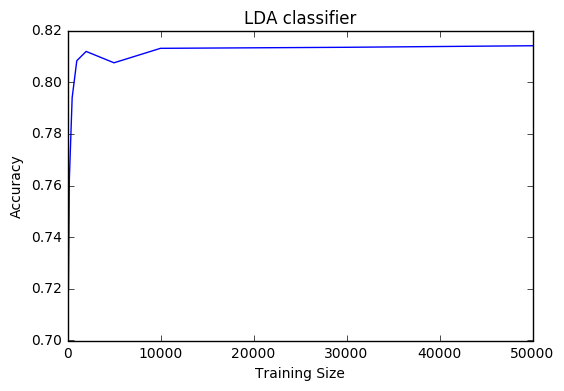

In [5]:
mnist_raw_data = scipy.io.loadmat('hw3_mnist_dist\\hw3_mnist_dist\\train.mat')[
        'trainX']
np.random.shuffle(mnist_raw_data)
validation_set = mnist_raw_data[:10000]
classifier = Gaussian_classifier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
training_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
scores = []
for i in training_sizes:
    classifier.fit(mnist_raw_data[10000:10000+i])
    scores.append(classifier.score(validation_set))
plt.plot(training_sizes, scores)
plt.title('LDA classifier')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.show()

# QDA

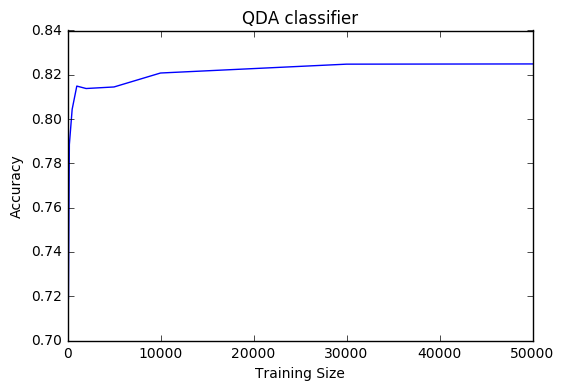

In [7]:
mnist_raw_data = scipy.io.loadmat('hw3_mnist_dist\\hw3_mnist_dist\\train.mat')[
        'trainX']
np.random.shuffle(mnist_raw_data)
validation_set = mnist_raw_data[:10000]
classifier = Gaussian_classifier([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
training_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
scores = []
for i in training_sizes:
    classifier.fit(mnist_raw_data[10000:10000+i])
    scores.append(classifier.scoreQDA(validation_set))
plt.plot(training_sizes, scores)
plt.title('QDA classifier')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.show()

Both my LDA and QDA performed almost identically for this, with QDA looking slightly better, but very close at around ~82% accuracy.

# Problem 3

Mean =  [3.194347785278191, 5.5316978258733096]
Covariance matrix = 
[[ 9.71709584  4.35777237]
 [ 4.35777237  5.69372982]]
Eigenvalues =  [ 12.50510538   2.90572029]
Eigenvectors = 
[[ 0.84235606 -0.53892139]
 [ 0.53892139  0.84235606]]


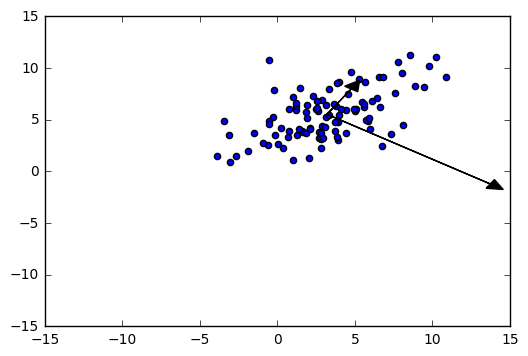

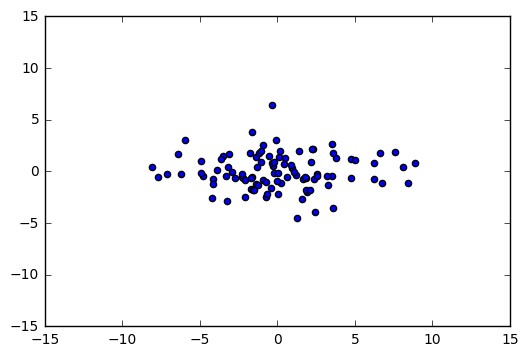

In [21]:
points = np.empty([100, 2])
for i in range(100):
    X1 = np.random.normal(3, 3)
    X2 = (.5*X1) + np.random.normal(4, 2)
    points[i] = [X1, X2]

mean1 = np.mean(points[:,0])
mean2 = np.mean(points[:,1])
cov_matrix = np.cov(points.T)
mean = [mean1, mean2]

print "Mean = ", [mean1, mean2]

print  "Covariance matrix = \n", cov_matrix

print "Eigenvalues = ", np.linalg.eig(cov_matrix)[0]
print "Eigenvectors = \n", np.linalg.eig(cov_matrix)[1]

x = np.arange(-15.0, 15.0, delta)
y = np.arange(-15.0, 15.0, delta)
X, Y = np.meshgrid(x, y)

plt.scatter(points[:,0], points[:,1])
plt.xlim(-15, 15)
plt.ylim(-15, 15)
ax = plt.axes()
eigenvectors = np.linalg.eig(cov_matrix)[1]
eigenvalues = np.linalg.eig(cov_matrix)[0]
norm = np.linalg.norm(eigenvectors[0])
ax.arrow(mean1, mean2, eigenvectors[0][0] * eigenvalues[0], eigenvectors[0][1] 
         * eigenvalues[0], head_width=1, head_length=1, fc='k', ec='k')
ax.arrow(mean1, mean2, eigenvectors[1][0] * eigenvalues[1], eigenvectors[1][1] 
         * eigenvalues[1], head_width=1, head_length=1, fc='k', ec='k')
plt.show()

rotated_points = np.empty([100, 2])
UT = eigenvectors.T
for i in range(100):
    rotated_points[i] = UT.dot(points[i] - mean)
    
plt.scatter(rotated_points[:,0], rotated_points[:,1])
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.show()
